In [1]:
from util import get_force_plot_ordering
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('dataset.pickle', 'rb') as f:
    X, y, feature_names, n_features, n_samples = pickle.load(f)

In [36]:
try:
    with open(f'shapvalues.soa.pred.pickle', 'rb') as f:
        shap_values_a, shap_values_b = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

And now we calculate SHAP values for each function:

In [3]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_a = explain(clf_a.predict)
shap_values_b = explain(clf_b.predict)

with open(f'shapvalues.soa.pred.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10.3 s, sys: 174 ms, total: 10.5 s
Wall time: 11.1 s


## Analyze

Preparations:

In [4]:
shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data
feature_order = np.flip(shap_values_a_vs_b.abs.mean(axis=0).values.argsort())

In [32]:
indices = np.indices(y.shape).ravel()
pred_a = clf_a.predict(X)
pred_b = clf_b.predict(X)
is_pred_equal = pred_a == pred_b
is_pred_diff = ~is_pred_equal

### Feature Importance

#### Bar Plots

Per default, the bar plot draws the mean absolute SHAP value per feature as an estimate for the feature importance.

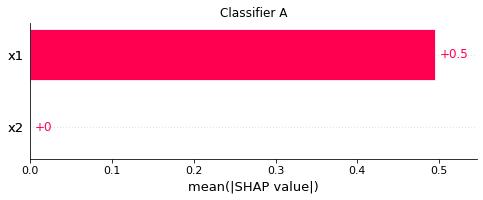

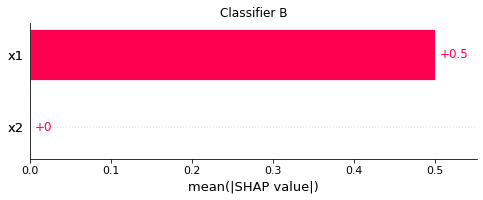

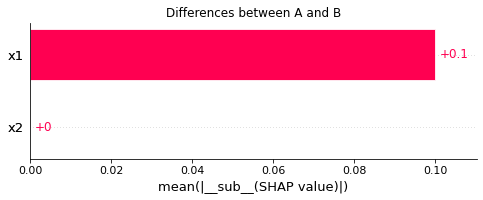

In [12]:
shap.plots.bar(shap_values_a, order=feature_order, max_display=n_features, show=False)
plt.title('Classifier A')
plt.show()
shap.plots.bar(shap_values_b, order=feature_order, max_display=n_features, show=False)
plt.title('Classifier B')
plt.show()
shap.plots.bar(shap_values_a_vs_b, order=feature_order, max_display=n_features, show=False)
plt.title('Differences between A and B')
plt.show()

#### SHAP Value Distribution

Next, we will try to understand the importances using the whole distribution of values, not only the aggregated mean.

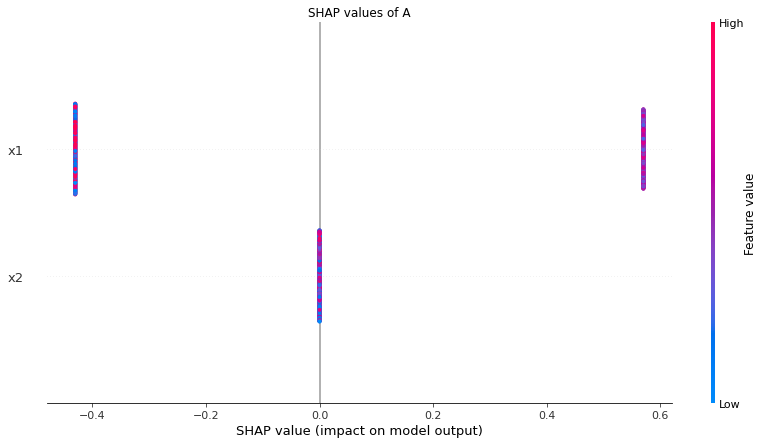

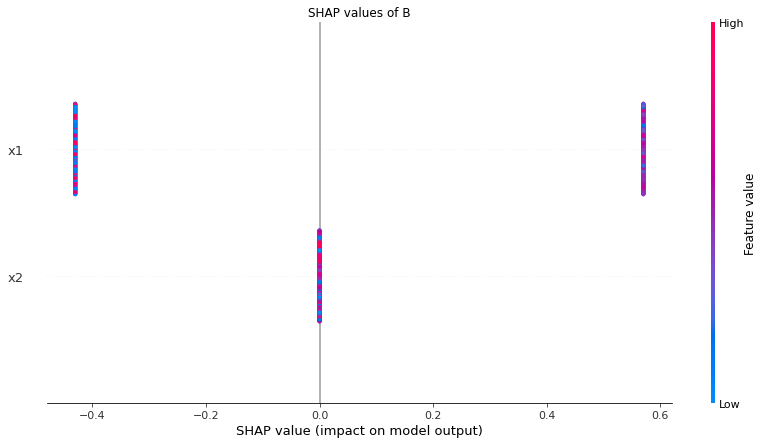

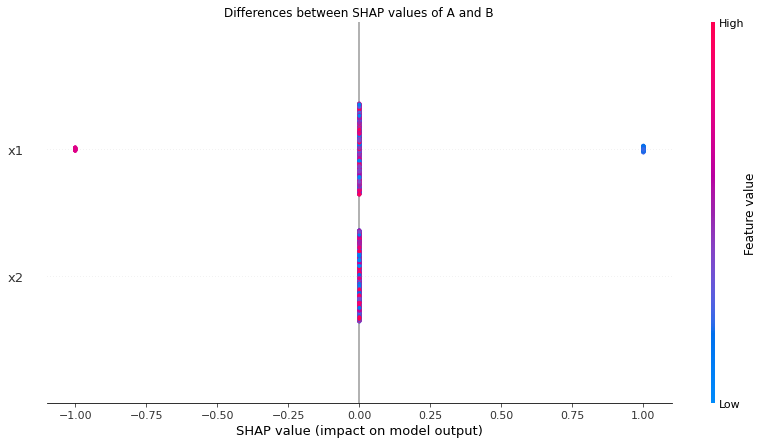

In [11]:
shap.plots.beeswarm(shap_values_a, order=feature_order, plot_size=(14, 7), show=False)
plt.title('SHAP values of A')
plt.show()
shap.plots.beeswarm(shap_values_b, order=feature_order, plot_size=(14, 7), show=False)
plt.title('SHAP values of B')
plt.show()
shap.plots.beeswarm(shap_values_a_vs_b, order=feature_order, plot_size=(14, 7), show=False)
plt.title('Differences between SHAP values of A and B')
plt.show()

### Feature Effects

#### Partial Dependence Plots

Here we investigate he effect a feature has no the model output. Plot in blue are the instances where A and B predict the same label, plot over in red are instances where they differ. The last column shows the difference between the two classifiers' SHAP values.

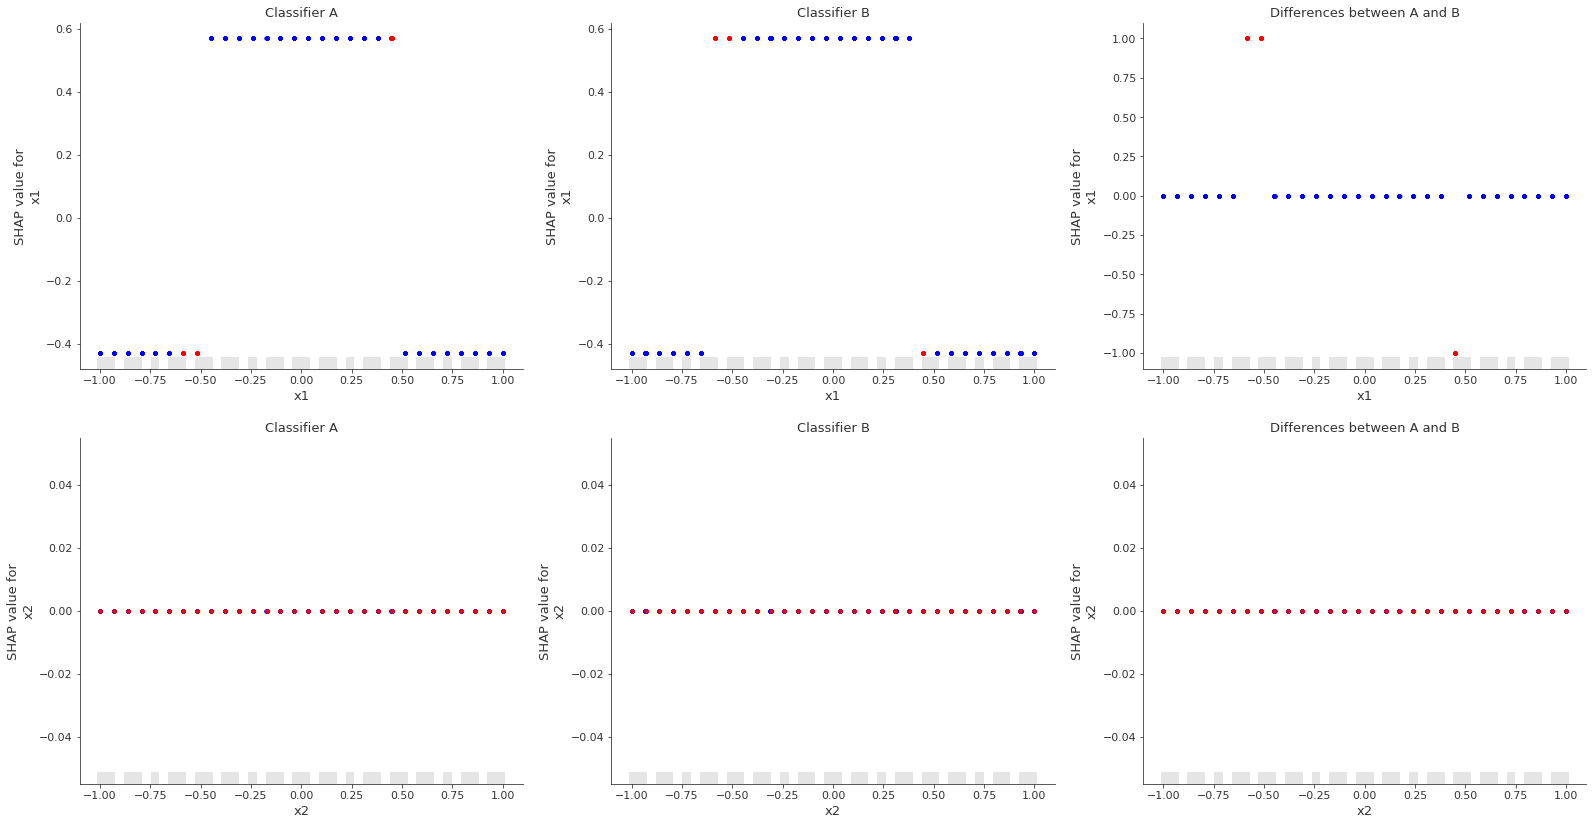

In [15]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=None)
    shap.plots.scatter(shap_values_a[:, feature], ax=ax1, color='blue', show=False)
    shap.plots.scatter(shap_values_a[is_pred_diff, feature], title='Classifier A', ax=ax1, color='red',  hist=False, show=False)
    shap.plots.scatter(shap_values_b[:, feature], ax=ax2, color='blue', dot_size=16, show=False)
    shap.plots.scatter(shap_values_b[is_pred_diff, feature], title='Classifier B', ax=ax2, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_a_vs_b[:, feature], ax=ax3, color='blue', show=False)
    shap.plots.scatter(shap_values_a_vs_b[is_pred_diff, feature], title='Differences between A and B', ax=ax3, color='red', hist=False, show=False)
    i += n_columns
plt.show()

### Cluster

#### Force plots

Visualize the SHAP values with their positive and negative forces on the prediction for a sample of the instances, ordered by similarity.

In [33]:
idx_diff = indices[is_pred_diff]
idx_equal = indices[is_pred_equal]
if len(idx_diff) > 500:
    idx_diff = shuffle(idx_diff, random_state=0, n_samples=500)
if len(idx_equal) > 500:
    idx_equal = shuffle(idx_equal, random_state=0, n_samples=500)

First, only instances which have a differing prediction:

In [34]:
ordering = None
for name, shap_values in zip(('A', 'B', 'A vs. B'), (shap_values_a, shap_values_b, shap_values_a_vs_b)):
    shap_values = shap_values[idx_diff]
    plot = shap.plots.force(base_value=shap_values.base_values[0], shap_values=shap_values.values, features=shap_values.display_data, feature_names=shap_values.feature_names, out_names=name, ordering_keys=ordering)
    display(plot)
    if not ordering:
        ordering = get_force_plot_ordering(plot)

And for instances, which have an equal prediction:

In [35]:
ordering = None
for name, shap_values in zip(('A', 'B', 'A vs. B'), (shap_values_a, shap_values_b, shap_values_a_vs_b)):
    shap_values = shap_values[idx_equal]
    plot = shap.plots.force(base_value=shap_values.base_values[0], shap_values=shap_values.values, features=shap_values.display_data, feature_names=shap_values.feature_names, out_names=name, ordering_keys=ordering)
    display(plot)
    if not ordering:
        ordering = get_force_plot_ordering(plot)

#### Heatmaps

SHAP heatmaps provide a way to cluster instances, using the hclust algorithm.

Classifier A:

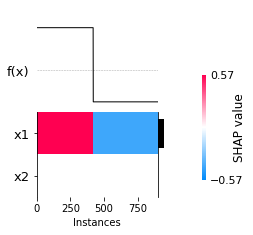

In [18]:
shap.plots.heatmap(shap_values_a, max_display=n_features, feature_order=feature_order)

Classifier B:

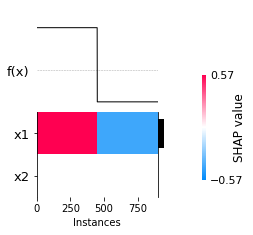

In [19]:
shap.plots.heatmap(shap_values_b, max_display=n_features, feature_order=feature_order)

Differences between A and B:

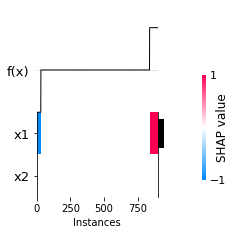

In [20]:
shap.plots.heatmap(shap_values_a_vs_b, max_display=n_features, feature_order=feature_order)